In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import tabulate

# Inline mode
%matplotlib inline
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import plot_roc_curve, roc_auc_score

# Hello Capstone!
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [2]:
# Import the Seattle Accident dataset
df = pd.read_csv('Data-Collisions.csv', low_memory = False)

# Show an overview
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
# Correct data types. First, show all the data types
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [4]:
# Data types are correct. Now, preprocess all datas
# First, derive the severity target variable by analyze the distribution of all datas
def get_replace_dict(ax, length):
    ''' Convenient function to gain the replace dictionary based on an index of data frame '''
    # Sort the array
    sarr = sorted(ax.value_counts().to_dict().items())
    
    # Obtain the threshold
    threshold = sum([a[1] for a in sarr]) / length
    
    # Keep adding values and split when reach the length
    ret = dict() # Returning dictionary
    cnt = 0 # Running counter
    temp_sum = 0 # Running sum
    for key, value in sarr:
        temp_sum += value
        ret[key] = cnt
        if temp_sum >= threshold:
            cnt += 1
            temp_sum = 0
    return ret

# Test
df['PERSONCOUNT'].replace(get_replace_dict(df['PERSONCOUNT'], 10)).value_counts()

0    132929
1     35553
2     21244
3      4947
Name: PERSONCOUNT, dtype: int64

In [5]:
# Now, preprocess the PERSONCOUNT, VEHCOUNT, PEDCOUNT and PEDCYLCOUNT
df['PERSONCOUNT'].replace(get_replace_dict(df['PERSONCOUNT'], 10), inplace = True)
df['VEHCOUNT'].replace(get_replace_dict(df['VEHCOUNT'], 20), inplace = True)
df['PEDCOUNT'].replace(get_replace_dict(df['PEDCOUNT'], 30), inplace = True)
df['PEDCYLCOUNT'].replace(get_replace_dict(df['PEDCYLCOUNT'], 30), inplace = True)

# Simply map severity code (1-2) to 0-1
df['SEVERITYCODE'].replace({1: 2, 0: 1}, inplace = True)

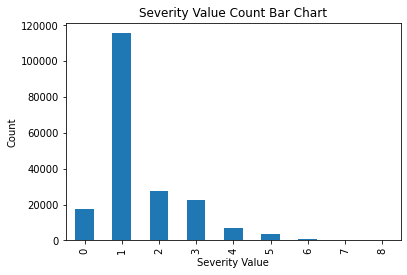

In [6]:
# From the report: sum up the five variable to obtain the severity (-2 for uniformize)
severity_array = df['SEVERITYCODE'] + df['PERSONCOUNT'] + df['VEHCOUNT'] + df['PEDCOUNT'] + df['PEDCYLCOUNT'] - 2

# Obtain a bar chart of the array
pd.DataFrame(sorted(severity_array.value_counts().to_dict().items())).iloc[:,1].plot(kind = 'bar')
plt.xlabel('Severity Value')
plt.ylabel('Count')
plt.title('Severity Value Count Bar Chart')
plt.savefig('images/severity_array_value.png')

In [7]:
# Process the independent variables
def change_to_numeric(col, assign_nan = None):
    ''' Convenient function to map strings to numerical. If assign_nan is None it will be assign to a new index '''
    # Use enumerate() for mapping
    temp = col.replace(dict([(v, k) for k, v in enumerate(col.value_counts().index)]))
    
    # assign NaN
    temp.replace(np.nan, len(col.value_counts()) if assign_nan is None else assign_nan, inplace = True)
    
    return temp.astype('int64')

# Collision type: Simple mapping to numerical numbers using enumerate()
df['COLLISIONTYPE'] = change_to_numeric(df['COLLISIONTYPE'])

In [8]:
# INCDATE and INCDTTM: change to datetime format and reduce into INCDTTM (according to the report).
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

In [9]:
# JUNCTIONTYPE: assign Unknown to majority (0)
df['JUNCTIONTYPE'] = change_to_numeric(df['JUNCTIONTYPE']).replace(len(df['JUNCTIONTYPE'].value_counts()) - 1, 0)

# INATTENTIONIND: NaN/Y -> 0/1
df['INATTENTIONIND'].replace({np.nan: 0, 'Y': 1}, inplace = True)

# UNDERINFL: Y/N -> 1/0
df['UNDERINFL'].replace({'N': 0, 'Y': 1, '0': 0, '1': 1, np.nan: 0}, inplace = True)

# PEDROWNOTGRNT: NaN/Y -> 0/1
df['PEDROWNOTGRNT'].replace({np.nan: 0, 'Y': 1}, inplace = True)

# SPEEDING: NaN/Y -> 0/1
df['SPEEDING'].replace({np.nan: 0, 'Y': 1}, inplace = True)

# HITPARKEDCAR: Y/N
df['HITPARKEDCAR'].replace({'N': 0, 'Y': 1, np.nan: 0}, inplace = True)

# WEATHER: combine to 0-3 (see Data section)
df['WEATHER'].replace({
    'Clear': 0, 'Partly Cloudy': 0, 'Overcast': 0, # Clear
    'Raining': 1, 'Snowing': 1, 'Sleet/Hail/Freezing Rain': 1, # Waterdrop
    'Blowing Sand/Dirt': 2, 'Severe Crosswind': 2, 'Fog/Smog/Smoke': 2, # Severe Conditions
    'Other': 3, 'Unknown': 3, np.nan: 3 # Others
}, inplace = True)

# ROADCOND: combine to 0-3
df['ROADCOND'].replace({
    'Dry': 0, # Good
    'Wet': 1, 'Sand/Mud/Dirt': 1, 'Oil': 1, # Sweeping
    'Ice': 2, 'Standing Water': 2, 'Snow/Slush': 2, # Bad
    'Other': 3, 'Unknown': 3, np.nan: 3 # Others
}, inplace = True)

# LIGHTCOND: combine to 0-3
df['LIGHTCOND'].replace({
    'Daylight': 0, # Light
    'Dawn': 1, 'Dusk': 1, 'Dark - Street Lights On': 1, 'Dark - Unknown Lighting': 1, # Partial Light
    'Dark - Street Lights Off': 2, 'Dark - No Street Lights': 2, # Dark
    'Other': 3, 'Unknown': 3, np.nan: 3 # Others
}, inplace = True)

In [10]:
# Fetch all the independent variable
indep_arr = df[['COLLISIONTYPE', 'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR']]
datetime_arr = df['INCDTTM']

# Display the target set
pd.concat([pd.DataFrame(severity_array, columns = ['SEVERITY']), indep_arr], axis = 1)

,SEVERITY,COLLISIONTYPE,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
0,1,1,1,0,0,0,1,0,0,0,0
1,1,4,0,0,0,1,1,1,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
194668,2,9,0,0,0,0,0,0,0,0,0
194669,1,2,0,1,0,1,1,0,0,0,0
194670,2,5,1,0,0,0,0,0,0,0,0
194671,1,7,1,0,0,0,0,1,0,0,0


In [11]:
# Split into train & test set (train is 75%)
x_train, x_test, y_train, y_test = train_test_split(indep_arr, severity_array, test_size = 0.25)

In [12]:
# Build a random forest classifier
clf = RandomForestClassifier()

# Train train set
clf.fit(x_train, y_train)

# Test for the test set
clf.score(x_test, y_test)

0.6524892642133596

In [13]:
# Cross validation
cross_score = cross_val_score(RandomForestClassifier(), indep_arr, severity_array, cv = 5)
np.mean(cross_score)

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.6531362657641082

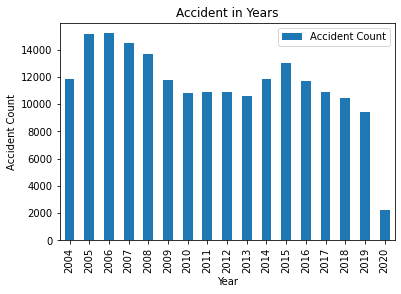

In [14]:
# Plot a bar chart for the accident years
pd.DataFrame([v for k, v in sorted(pd.DataFrame([a.year for a in datetime_arr]).value_counts().to_dict().items())], index = [k[0] for k, v in sorted(pd.DataFrame([a.year for a in datetime_arr]).value_counts().to_dict().items())], columns = ["Accident Count"]).plot(kind = 'bar')

# Add labels and save
plt.xlabel("Year")
plt.ylabel("Accident Count")
plt.title("Accident in Years")
plt.savefig("images/accident_years.png")

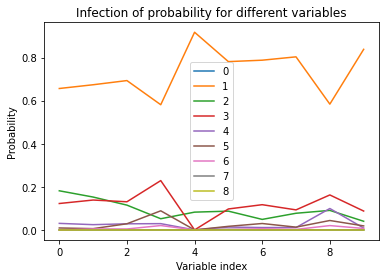

In [15]:
# Plot of predict values
plt.plot(range(0, 10), clf.predict_proba([[(1 if i == j else 0) for j in range(0, 10)] for i in range(0, 10)]))
plt.xlabel('Variable index')
plt.ylabel('Probability')
plt.legend(range(0, 10))
plt.title('Infection of probability for different variables')
plt.savefig('images/prob_line.png')

Text(0.5, 1.0, 'Infection of probability for different variables')

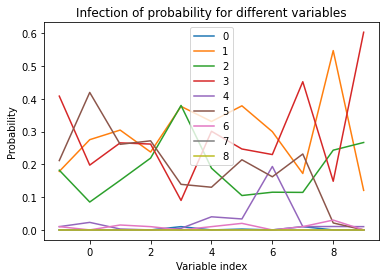

In [16]:
plt.plot(range(-1, 10), clf.predict_proba([[(0 if i == j else 1) for j in range(0, 10)] for i in range(-1, 10)]))
plt.xlabel('Variable index')
plt.ylabel('Probability')
plt.legend(range(0, 10))
plt.title('Infection of probability for different variables')